In [7]:
# Convert .srt subtitles to CSV data file

import os
import csv


def srt_to_csv(srt_directory, output_csv, word_separator):
    with open(output_csv, mode="w", newline="", encoding="utf-8") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["text"])

        filenames = os.listdir(srt_directory)
        filenames.sort()
        for filename in filenames:
            if filename.endswith(".srt"):
                with open(os.path.join(srt_directory, filename), "r", encoding="utf-8") as srt_file:
                    lines = srt_file.readlines()
                    text_lines = []
                    for line in lines:
                        line = line.strip()
                        if (
                            line
                            and not line.isdigit()
                            and "-->" not in line
                            and "\ufeff1" not in line
                        ):
                            text_lines.append(line)
                        else:
                            if text_lines:
                                writer.writerow(
                                    [word_separator.join(text_lines).replace("{\\an8}", "")]
                                )
                                text_lines = []
                    if text_lines:
                        writer.writerow([word_separator.join(text_lines).replace("{\\an8}", "")])


if __name__ == "__main__":
    srt_to_csv("data/chinese/srt", "data/chinese/all.csv", "")
    srt_to_csv("data/english/srt", "data/english/all.csv", " ")


In [ ]:
# Use transformer to annotate data with sentiment

# Since transformer is much more precise than Naive Bayes, SVM, SVC, Decision Tree and KNN,
# there's no problem to use it to generate the sentiment annotation of the entire dataset.

import pandas as pd
import csv
from transformers import pipeline


def annotate_sentiment(input_csv, output_csv, model_name):
    sentences = pd.read_csv(input_csv)["text"].to_list()

    annotated_sentences = []
    sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)
    results = sentiment_pipeline(sentences)
    for result in enumerate(results):
        annotated_sentences.append((sentences[result[0]], result[1]["score"], result[1]["label"]))

    with open(output_csv, "w", encoding="utf-8", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["text", "score", "label"])
        writer.writerows(annotated_sentences)


if __name__ == "__main__":
    annotate_sentiment(
        "data/chinese/all.csv",
        "data/chinese/all_with_sentiment.csv",
        "IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment",
    )
    annotate_sentiment(
        "data/english/all.csv",
        "data/english/all_with_sentiment.csv",
        "distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    )


                     text     score     label
0       被疯王路德维希请进林德霍夫堡的宾客  0.967135  Negative
1                     真讨厌  0.999163  Negative
2                      退后  0.978006  Negative
3      别逗了 都这么久了这些陷阱怎么可能…  0.998529  Negative
4             肯定有机关保护这些宝藏  0.947419  Positive
...                   ...       ...       ...
1447  〝我们很高兴小玉在美国学到了很多东西〞  0.995905  Positive
1448            你会演一辈子的戏吗  0.958664  Negative
1449             其他的事我都不懂  0.995266  Negative
1450                我只懂电影  0.996957  Negative
1451          我这辈子只会干电影这行  0.994829  Negative

[1452 rows x 3 columns]


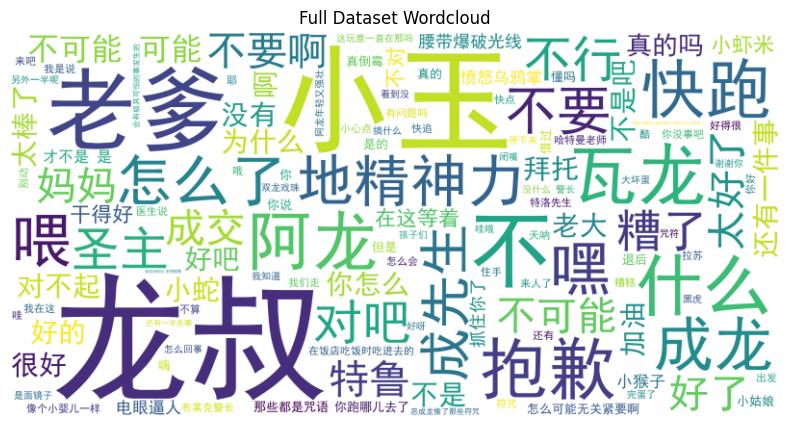

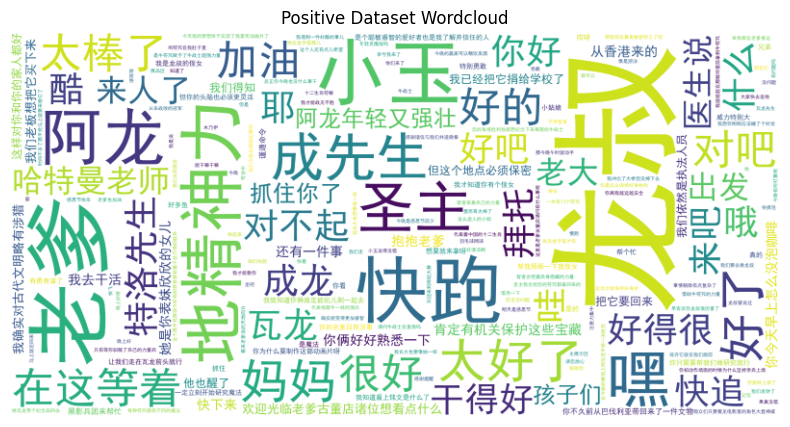

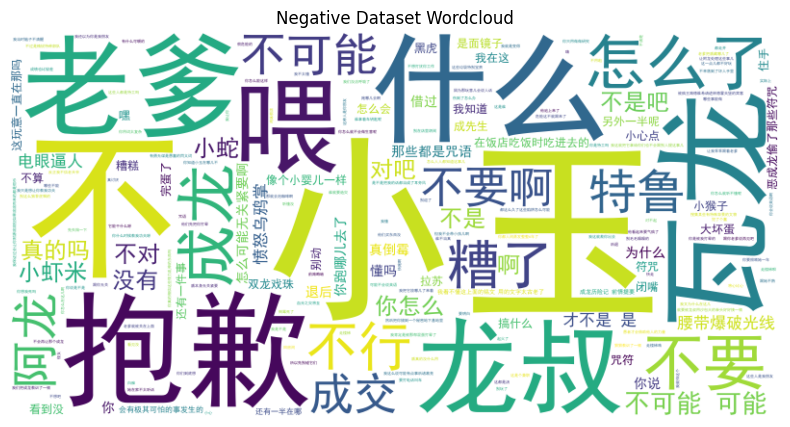


    Model: Naive Bayes
              precision    recall  f1-score   support

    Negative       0.84      0.94      0.89       186
    Positive       0.86      0.70      0.77       105

    accuracy                           0.85       291
   macro avg       0.85      0.82      0.83       291
weighted avg       0.85      0.85      0.84       291


    Model: SVM
              precision    recall  f1-score   support

    Negative       0.77      0.97      0.86       186
    Positive       0.90      0.50      0.64       105

    accuracy                           0.80       291
   macro avg       0.83      0.73      0.75       291
weighted avg       0.82      0.80      0.78       291


    Model: Decision Tree
              precision    recall  f1-score   support

    Negative       0.81      0.94      0.87       186
    Positive       0.85      0.61      0.71       105

    accuracy                           0.82       291
   macro avg       0.83      0.78      0.79       291
weighted

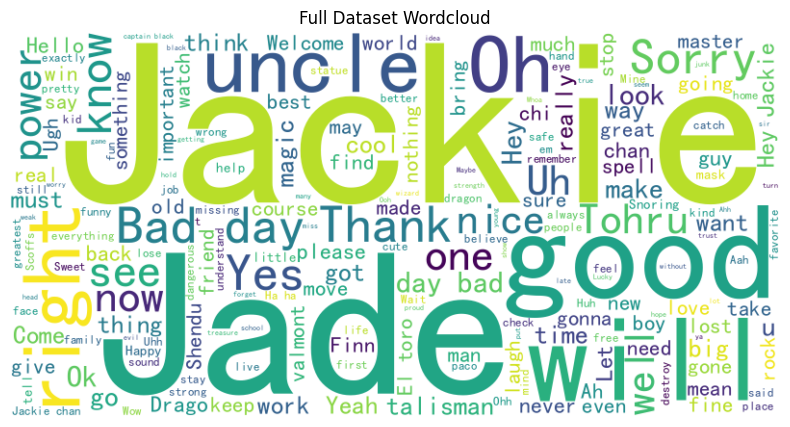

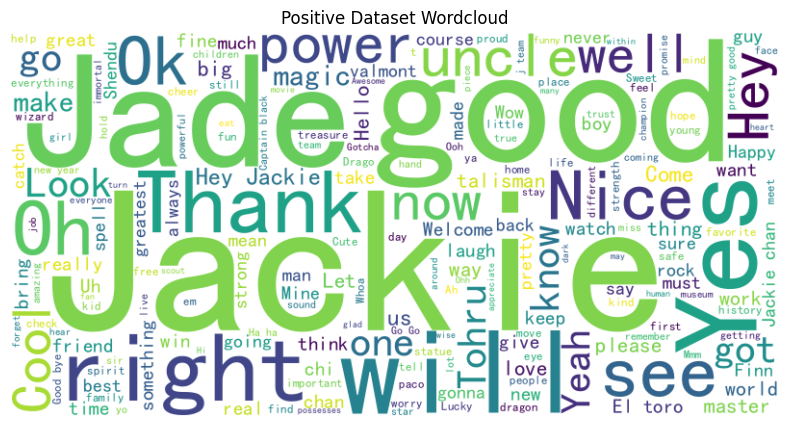

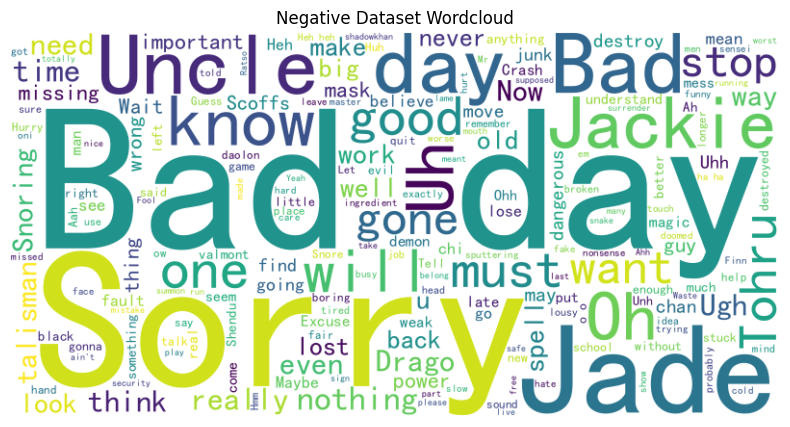


    Model: Naive Bayes
              precision    recall  f1-score   support

    NEGATIVE       0.89      0.79      0.84       441
    POSITIVE       0.90      0.95      0.92       864

    accuracy                           0.90      1305
   macro avg       0.90      0.87      0.88      1305
weighted avg       0.90      0.90      0.90      1305


    Model: SVM
              precision    recall  f1-score   support

    NEGATIVE       0.94      0.68      0.79       441
    POSITIVE       0.86      0.98      0.91       864

    accuracy                           0.88      1305
   macro avg       0.90      0.83      0.85      1305
weighted avg       0.88      0.88      0.87      1305


    Model: Decision Tree
              precision    recall  f1-score   support

    NEGATIVE       0.89      0.82      0.85       441
    POSITIVE       0.91      0.95      0.93       864

    accuracy                           0.90      1305
   macro avg       0.90      0.88      0.89      1305
weighted

In [8]:
# Perform regular tasks

import pandas as pd
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import jieba


# (1) 数据集装载、显示
def load_data(file_path: str, threshold):
    data = pd.read_csv(file_path)
    data = data[
        (
            (data["label"].astype(str).str.lower() == "positive")
            & (data["score"] >= threshold["positive"])
        )
        | (
            (data["label"].astype(str).str.lower() == "negative")
            & (data["score"] >= threshold["negative"])
        )
    ].reset_index(drop=True)
    print(data)
    return data


# (2) 分词
def vectorize_en(text):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(text), vectorizer


def vectorize_ch(text):
    text = [" ".join(jieba.lcut(string)) for string in text]
    vectorizer = CountVectorizer()
    tokens = vectorizer.fit_transform(text)
    return tokens, vectorizer


# (3) 全集、分类别子集的词云可视化
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, height=400, background_color="white", font_path="simhei.ttf"
    ).generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()


# (4) 分类模型（多种分类算法）
def train_models(X_train, y_train):
    models = {
        "Naive Bayes": MultinomialNB(),
        "SVM": SVC(),
        "Decision Tree": DecisionTreeClassifier(),
        "KNN": KNeighborsClassifier(),
    }
    for name, model in models.items():
        model.fit(X_train, y_train)
        models[name] = model
    return models


# (5) 分类效果评价（accuracy, precision, recall）
def evaluate_models(models, X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print()
        print(f"    Model: {name}")
        print(classification_report(y_test, y_pred))


# (6) 利用模型，对单一文档进行分类
def classify_document(model, vectorizer, document):
    tokens = vectorizer.transform([document])
    prediction = model.predict(tokens)
    return prediction


def analyze(filename, threshold, vectorizer):
    data = load_data(filename, threshold)
    X, vectorizer = vectorizer(data["text"])
    y = data["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    generate_wordcloud(data["text"], "Full Dataset Wordcloud")
    generate_wordcloud(
        data[data["label"].astype(str).str.lower() == "positive"]["text"],
        "Positive Dataset Wordcloud",
    )
    generate_wordcloud(
        data[data["label"].astype(str).str.lower() == "negative"]["text"],
        "Negative Dataset Wordcloud",
    )

    models = train_models(X_train, y_train)
    evaluate_models(models, X_test, y_test)

    for i in range(20):
        print()
        print(f"Document {i + 1}: {data['text'][i]}")
        print(
            f"Predicted Label: {classify_document(models['Naive Bayes'], vectorizer, data['text'][i])[0]}"
        )
        print(f"Actual Label: {data['label'][i]}")


if __name__ == "__main__":
    analyze(
        "data/chinese/all_with_sentiment.csv", {"positive": 0.900, "negative": 0.900}, vectorize_ch
    )
    analyze(
        "data/english/all_with_sentiment.csv", {"positive": 0.999, "negative": 0.999}, vectorize_en
    )
